In [4]:
#Ens connectem a la GPU
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [5]:
#Lliberies utilitzades
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from tqdm import tqdm
import nibabel as nib
import cv2
import numpy as np
from sklearn.model_selection import KFold 

/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tfg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarnin

In [7]:
path = "HGG/HGG/"

In [1]:
#Funció per llegir les imatges de la base de dades
def load_data(path,mida):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  i=1
  flair=[]
  for p in tqdm(my_dir): 
    if(p.startswith('Brats18')):
        data_list = sorted(os.listdir(path+p))       
    
        seg = nib.load(path + p + '/'+ data_list[1]).get_fdata()
        seg=seg[40:200,30:220,:]
        seg=cv2.resize(seg,(240,240))
        
        flair = nib.load(path + p + '/'+ data_list[0]).get_fdata()
        flair=flair[40:200,30:220,:]
        flair=cv2.resize(flair,(240,240))
        
        t2 = nib.load(path + p + '/'+ data_list[4]).get_fdata()
        t2=t2[40:200,30:220,:]
        t2=cv2.resize(t2,(240,240))
        
        data.append([flair,t2])
        gt.append(seg)
        if i>mida:
          break
        else:
          i=i+1
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data,gt,flair

In [2]:
nombre_mostres=285

In [3]:
data1,gt1,flair = load_data(path,nombre_mostres)   #dividing HGG in three parts i.e. 210 into three sets of 70 

NameError: name 'path' is not defined

In [99]:
#Modifiquem la forma dels vectors
data = np.transpose(data1,(0,4,2,3,1))
gt1=np.swapaxes(gt1,1,3)
gt1=np.swapaxes(gt1,2,3)
data = data.reshape([-1,240,240,2])
gt_final = gt1.reshape([-1,240,240,1])

In [111]:
#Canviem els valors del vector gt_final
gt_final[np.where(gt!=0)]=1 

In [28]:
#Estructura de la U-NET
def unet():
    
    inputs = Input((240 , 240 , 2))
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512,3, activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(batch4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization()(conv5)
    
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', activation='relu') (batch5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same') (up6)
    batch6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512,3, activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization()(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', activation='relu') (batch6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256,3, activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256,3, activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization()(conv7)
    
    up8 = Conv2DTranspose(128,2, strides=(2, 2), padding='same', activation='relu') (batch7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128,3, activation='relu', padding='same') (up8)
    batch8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128,3, activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64,2, strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1,1,activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

    return model

In [29]:
#Dividim la base de dades en train i test
percentatge=abs(nombre_mostres*0.8)
#Train
input_train=data[0:int(percentatge*155),:,:,:]
target_train=gt_final[0:int(percentatge*155),:,:]
#Test
input_test=data[int(percentatge*155):,:,:,:]
target_test=gt_final[int(percentatge*155):,:,:,:]


In [31]:
#Funcions que calculen el dice
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

def mean_dice_coef(y_true, y_pred_bin):
    batch_size = y_true.shape[0]
    mean_dice_channel = 0.
    vector_dice=[]
    compt=1
    total_dice=[]
    for i in range(batch_size):
        if compt==155:
                vector_dice.append(dice_coef(y_true[i, :, :, 0], y_pred_bin[i, :, :,0]))
                total_dice.append(np.mean(vector_dice))
                vector_dice=[]
                compt=1
        else:
                vector_dice.append(dice_coef(y_true[i, :, :, 0], y_pred_bin[i, :, :,0]))
                compt=compt+1
    return total_dice

In [32]:
num_folds=5
inputs = input_train
targets =target_train
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=100)
fold_no=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
28272/28272 [==============================] - 909s 32ms/step - loss: 1.2835
Epoch 2/50
28272/28272 [==============================] - 903s 32ms/step - loss: 0.1569
Epoch 3/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.1099
Epoch 4/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0877
Epoch 5/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0735
Epoch 6/50
28272/28272 [==============================] - 901s 32ms/step - loss: 0.0674
Epoch 7/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0586
Epoch 8/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0540
Epoch 9/50
28272/28272 [==============================] - 901s 32ms/step - loss: 0.0491
Epoch 10/50
28272/28272 [==============================] - 902s 32ms/step - loss: 0.0457
Epoch 11/50
28272/2827

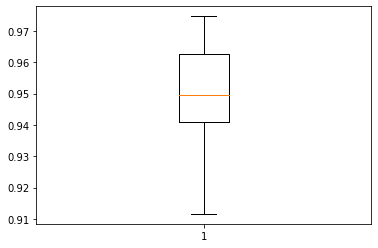

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
28272/28272 [==============================] - 911s 32ms/step - loss: 1.3181
Epoch 2/50
28272/28272 [==============================] - 905s 32ms/step - loss: 0.1555
Epoch 3/50
28272/28272 [==============================] - 905s 32ms/step - loss: 0.1037
Epoch 4/50
28272/28272 [==============================] - 905s 32ms/step - loss: 0.0846
Epoch 5/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0760
Epoch 6/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0659
Epoch 7/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0599
Epoch 8/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0544
Epoch 9/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0495
Epoch 10/50
28272/28272 [==============================] - 904s 32ms/step - loss: 0.0465
Epoch 11/50
28272/2827

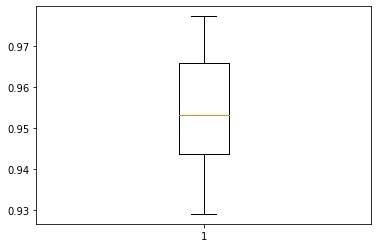

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
28272/28272 [==============================] - 914s 32ms/step - loss: 1.2837
Epoch 2/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.1526
Epoch 3/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.1080
Epoch 4/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.0870
Epoch 5/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.0768
Epoch 6/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0681
Epoch 7/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.0605
Epoch 8/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.0545
Epoch 9/50
28272/28272 [==============================] - 907s 32ms/step - loss: 0.0504
Epoch 10/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0495
Epoch 11/50
28272/2827

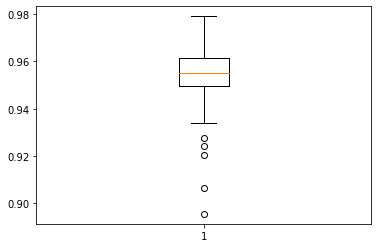

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
28272/28272 [==============================] - 918s 32ms/step - loss: 1.2046
Epoch 2/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.1461
Epoch 3/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.1018
Epoch 4/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0837
Epoch 5/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0743
Epoch 6/50
28272/28272 [==============================] - 910s 32ms/step - loss: 0.0642
Epoch 7/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0582
Epoch 8/50
28272/28272 [==============================] - 910s 32ms/step - loss: 0.0522
Epoch 9/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0484
Epoch 10/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0442
Epoch 11/50
28272/2827

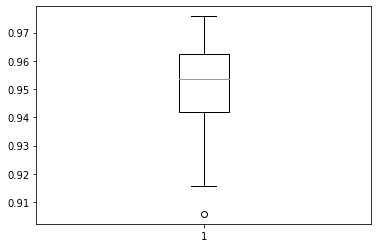

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
28272/28272 [==============================] - 918s 32ms/step - loss: 1.2505
Epoch 2/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.1630
Epoch 3/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.1138
Epoch 4/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0969
Epoch 5/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0802
Epoch 6/50
28272/28272 [==============================] - 909s 32ms/step - loss: 0.0719
Epoch 7/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0642
Epoch 8/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0579
Epoch 9/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0527
Epoch 10/50
28272/28272 [==============================] - 908s 32ms/step - loss: 0.0488
Epoch 11/50
28272/2827

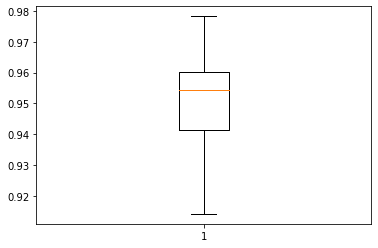

In [35]:
#Entrenem els models
loss_per_fold=[]
vec_models=[]
scores_dice_total=[]
for train, test in kfold.split(inputs, targets):
    model = unet()
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(inputs[train], targets[train],batch_size=8,epochs=50)
    vec_models.append(model)
    
    #Predim el model
    prediccio=model.predict(inputs[test])
    dades=inputs[test]
    dades=np.where(dades<0.5,0,1)
    prediccio=prediccio*dades
    prediccio=np.where(prediccio<0.5,0,1)
    
    #Calculem dice del model corresponent
    score=mean_dice_coef(prediccio,targets[test])
    
    #Calculem loss del model corresponent
    scores_lose = model.evaluate(inputs[test], targets[test], verbose=0)
    
    #Mostrem els resultats
    scores_dice=np.mean(score)
    dice_coeficient="['dice_coef']"
    print(f'Score for fold {fold_no}: {model.metrics_names} of {scores_lose}%')
    print(f'Score for fold {fold_no}: {dice_coeficient} of {scores_dice}%')
    
    #Creem boxplot
    plt.boxplot(score)
    plt.show()
    scores_dice_total.append(score)
    score=[]
    prediccio=[]
    score_dice=0
    loss_per_fold.append(scores_lose)
    fold_no = fold_no + 1

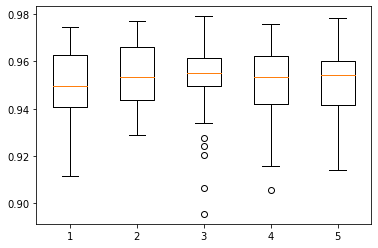

In [36]:
plt.boxplot(scores_dice_total)
plt.show()

In [37]:
#Guardem els models que acabem d'entrenar
vec_models[0].save('#2.1#SB_+BC_5_fold_50_epochs.h5')
vec_models[1].save('#2.2#SB_+BC_5_fold_50_epochs.h5')
vec_models[2].save('#2.3#SB_+BC_5_fold_50_epochs.h5')
vec_models[3].save('#2.4#SB_+BC_5_fold_50_epochs.h5')
vec_models[4].save('#2.5#SB_+BC_5_fold_50_epochs.h5')

# AGAFEM EL MAXIM DELS 5 MODELS

In [39]:
Y_pre1=vec_models[0].predict(input_test)
Y_pre2=vec_models[1].predict(input_test)
Y_pre3=vec_models[2].predict(input_test)
Y_pre4=vec_models[3].predict(input_test)
Y_pre5=vec_models[4].predict(input_test)

Dice maxim dels 5 models: 0.7802468923207189%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f99fb150518>,
 'caps': [<matplotlib.lines.Line2D at 0x7f99fb150ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f99fb1502b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f99fb0dd0b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f99fb0dd390>],
 'means': []}

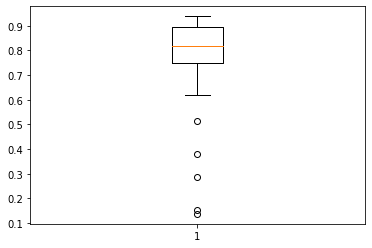

In [40]:
#Creem un model amb el valor del píxel més gran de tots els 5 models
Y_pre_total_maxim=np.maximum(Y_pre1,Y_pre2)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre3)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre4)
Y_pre_total_maxim=np.maximum(Y_pre_total_maxim,Y_pre5)

Y_pre_total_maxim[np.where(Y_pre_total_maxim<0.5)]=0
Y_pre_total_maxim[np.where(Y_pre_total_maxim>=0.5)]=1

input_test=np.array(input_test,copy=True)
input_test2=input_test.copy()
input_test2[np.where(input_test2>0)]=1
Y_pre_total_maxim=Y_pre_total_maxim*input_test2

#Calculem accuracy
dades=mean_dice_coef(target_test, Y_pre_total_maxim)
print(f'Dice maxim dels 5 models: {np.mean(dades)}%')
plt.boxplot(dades)

input_test 80


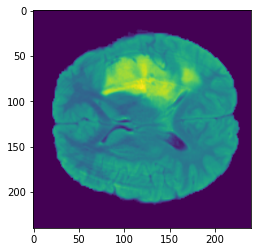

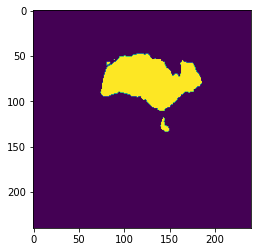

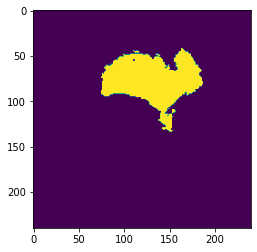

input_test 81


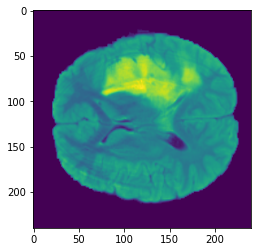

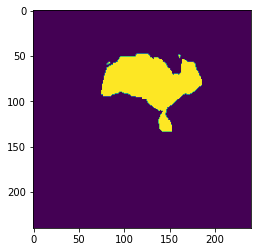

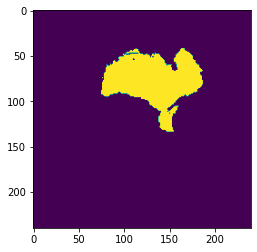

input_test 82


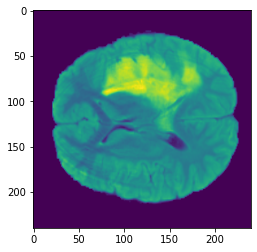

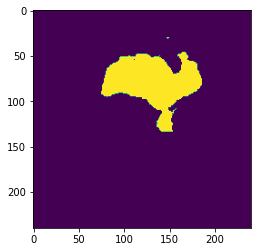

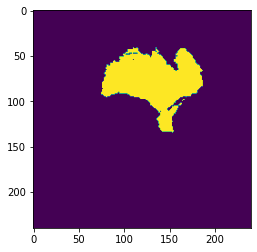

input_test 83


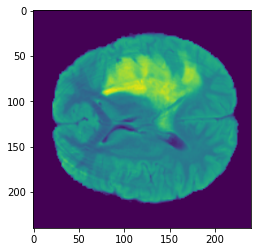

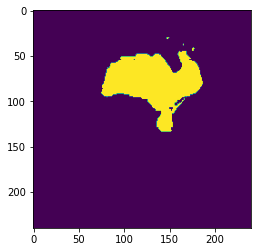

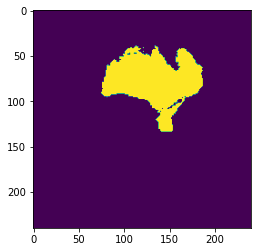

input_test 84


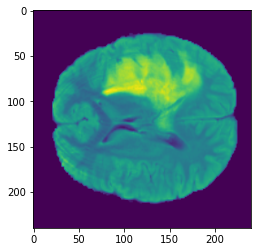

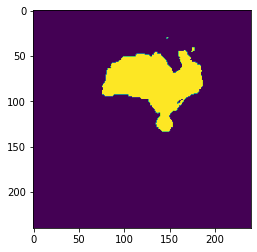

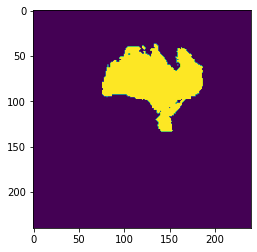

input_test 85


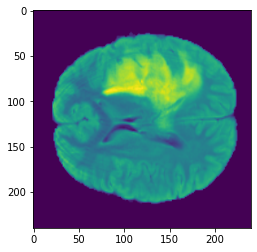

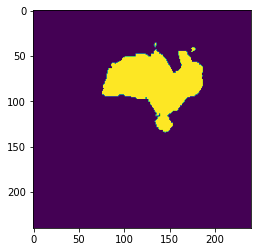

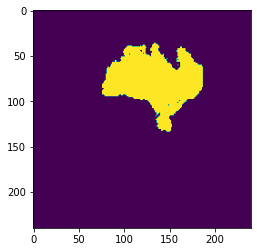

input_test 86


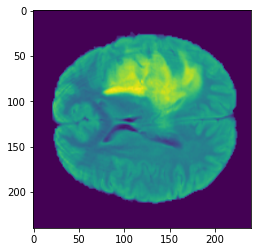

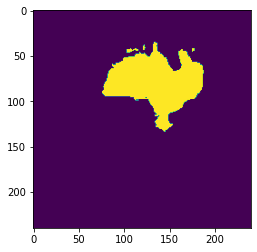

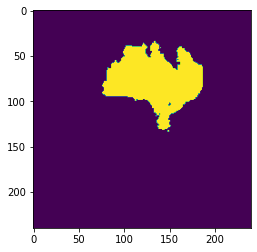

input_test 87


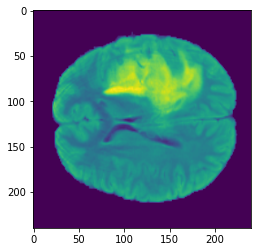

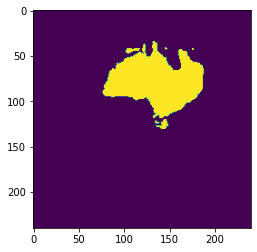

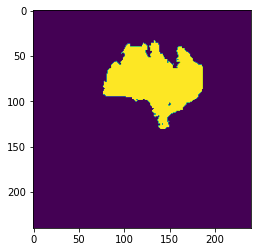

input_test 88


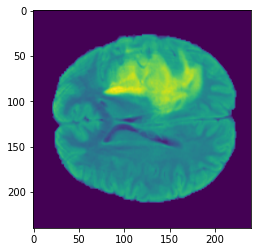

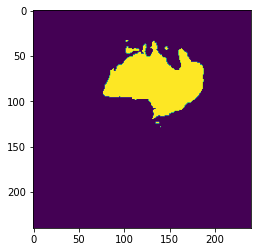

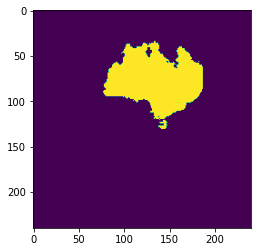

input_test 89


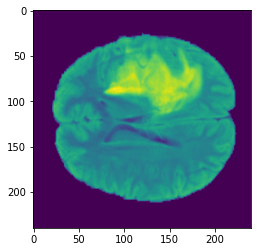

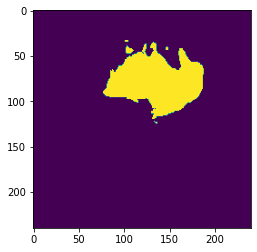

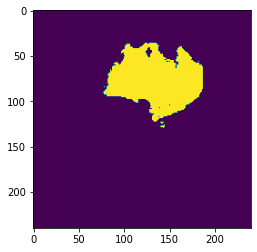

In [41]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_total_maxim[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# AGAFEM LA MITJANA DELS 5 MODELS

Dice maxim dels 5 models: 0.8245470806436926%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f99fa63cb70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f99fa64e160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f99fa63c908>],
 'medians': [<matplotlib.lines.Line2D at 0x7f99fa64e710>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f99fa64e9e8>],
 'means': []}

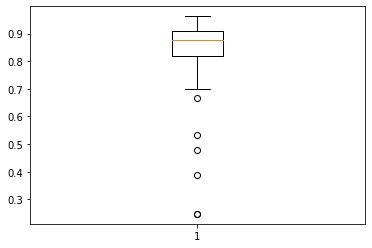

In [42]:
#Creem un model amb la mitjana dels valors dels píxels dels 5 models
Y_pre_total_mitjana=Y_pre1+Y_pre2+Y_pre3+Y_pre4+Y_pre5
Y_pre_total_mitjana=Y_pre_total_mitjana/5

Y_pre_total_mitjana[np.where(Y_pre_total_mitjana<0.5)]=0
Y_pre_total_mitjana[np.where(Y_pre_total_mitjana>=0.5)]=1
Y_pre_total_mitjana=Y_pre_total_mitjana*input_test2

#Calculem accuracy
dades=mean_dice_coef(target_test, Y_pre_total_mitjana)
print(f'Mitjana dels 5 models: {np.mean(dades)}%')
plt.boxplot(dades)

input_test 80


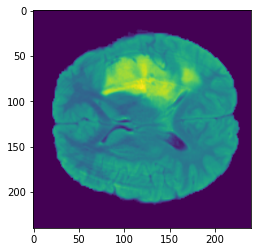

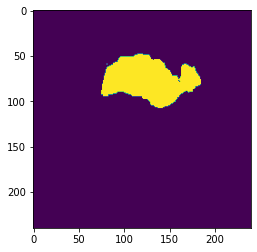

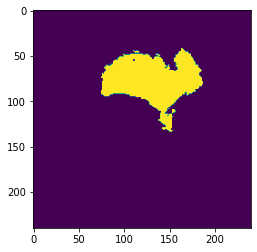

input_test 81


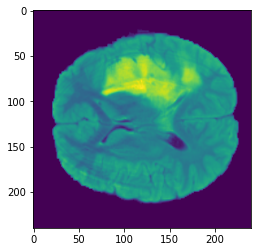

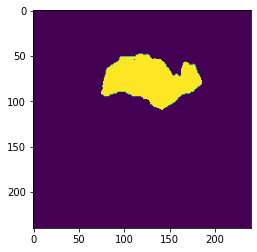

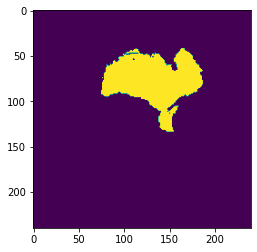

input_test 82


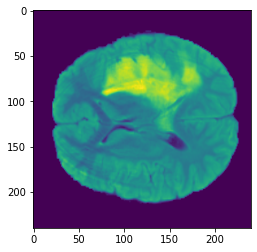

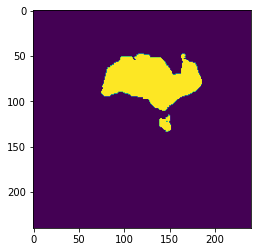

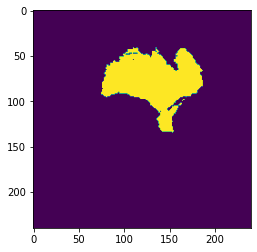

input_test 83


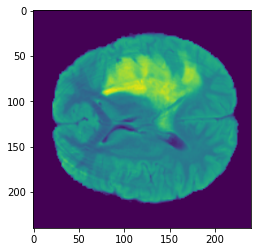

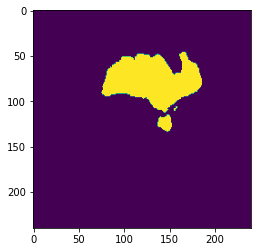

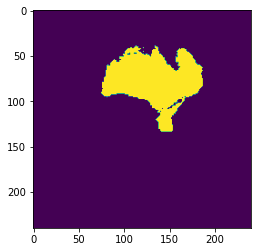

input_test 84


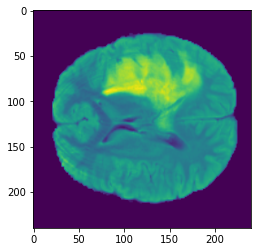

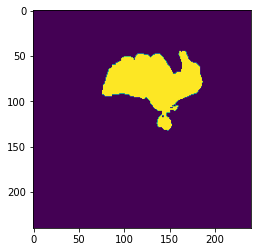

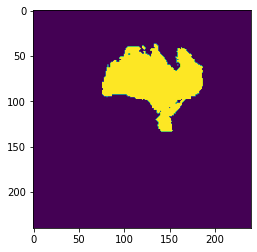

input_test 85


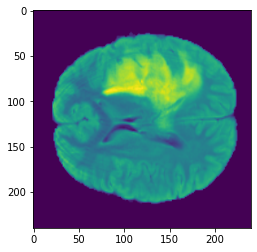

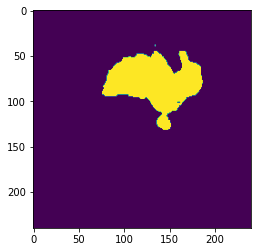

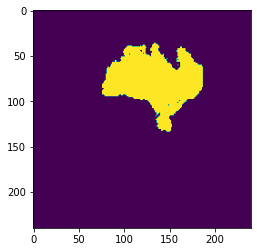

input_test 86


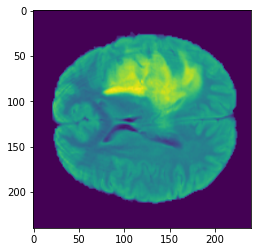

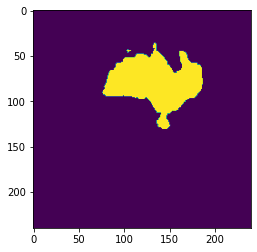

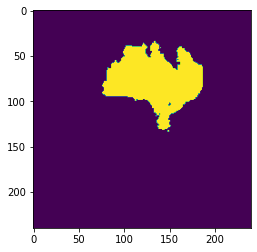

input_test 87


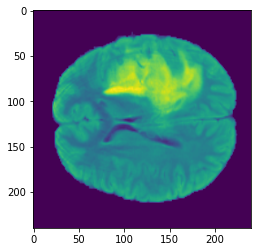

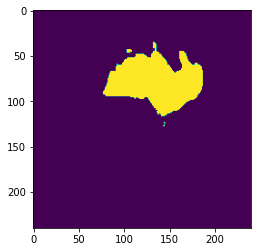

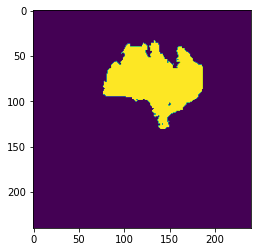

input_test 88


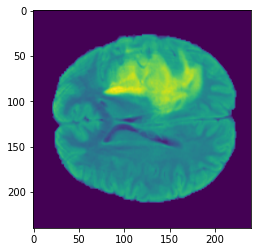

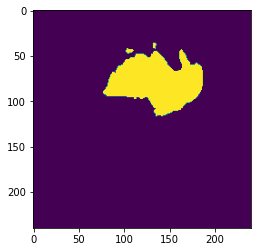

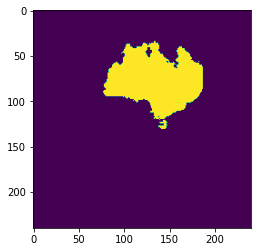

input_test 89


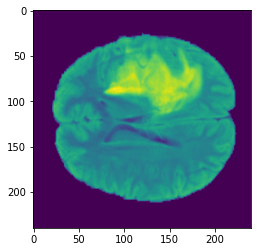

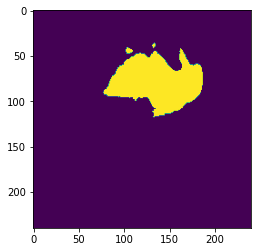

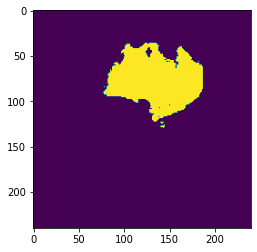

In [43]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_total_mitjana[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# AGAFEM EL MODEL AMB LA LOSS MÉS BAIXA

Dice maxim dels 5 models: 0.802882534298811%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f99f1b1a7f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f99f1b1ada0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f99f1b1a588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f99f1b28390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f99f1b28668>],
 'means': []}

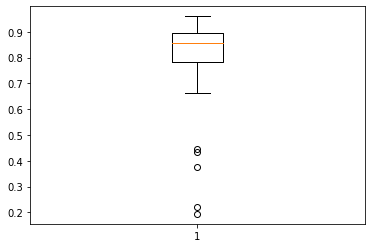

In [44]:
#Ens quedem amb el model amb la loss més baixa
index_lowest_loss=np.where(loss_per_fold==np.min(loss_per_fold))
index_lowest_loss=np.asarray(index_lowest_loss)
np.savetxt('#1.6# index.txt',index_lowest_loss)
valor=int(index_lowest_loss[0])
model_lowest_low=vec_models[valor]

Y_pre_lowest_low=model_lowest_low.predict(input_test)
Y_pre_lowest_low[np.where(Y_pre_lowest_low<0.5)]=0
Y_pre_lowest_low[np.where(Y_pre_lowest_low>=0.5)]=1
Y_pre_lowest_low=Y_pre_lowest_low*input_test2

#Calculem dice
dades=mean_dice_coef(target_test, Y_pre_lowest_low)
print(f'Dice loss més petita: {np.mean(dades)}%')
plt.boxplot(dades)

input_test 80


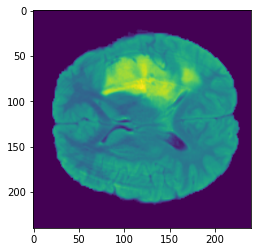

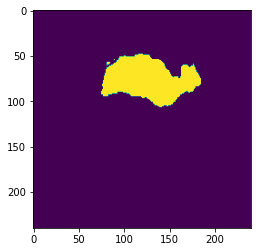

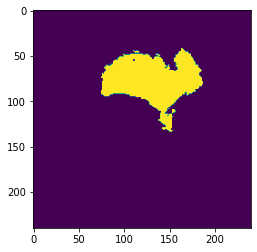

input_test 81


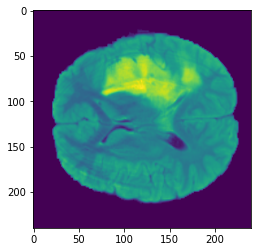

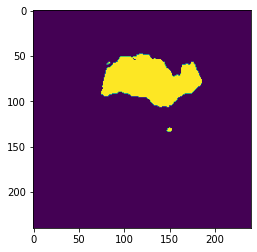

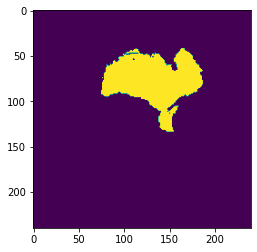

input_test 82


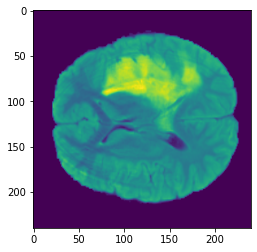

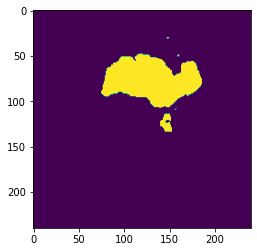

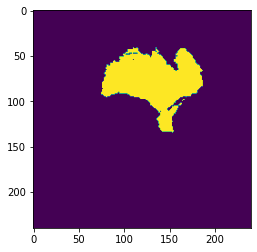

input_test 83


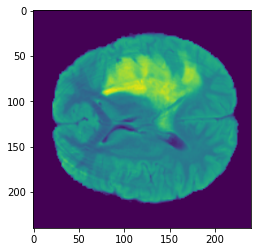

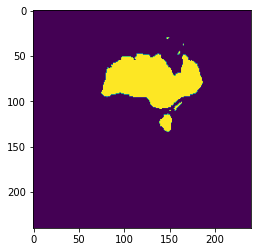

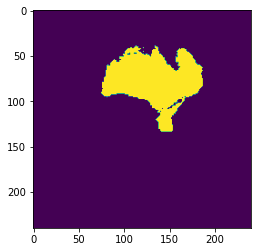

input_test 84


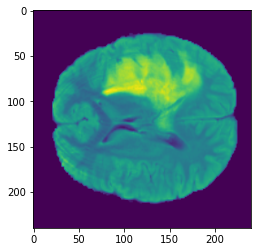

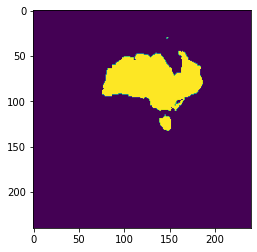

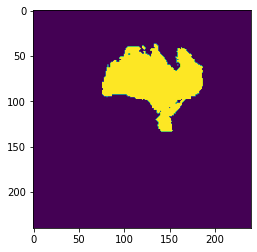

input_test 85


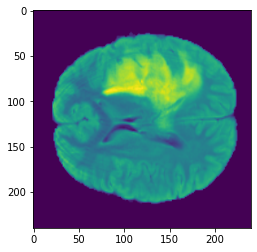

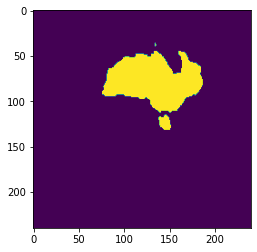

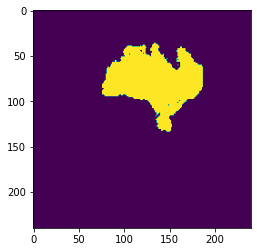

input_test 86


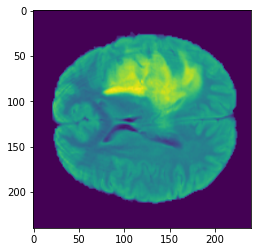

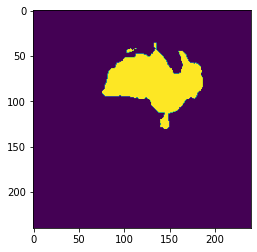

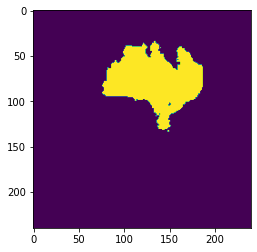

input_test 87


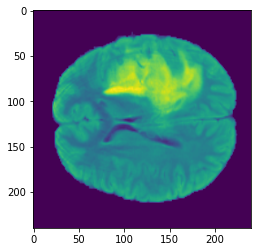

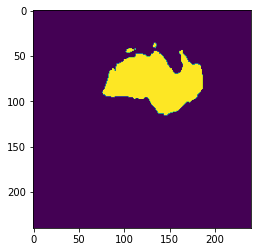

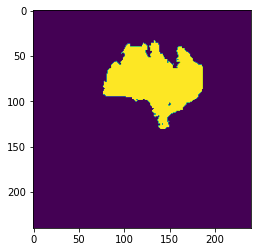

input_test 88


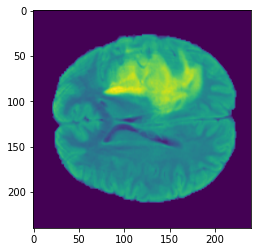

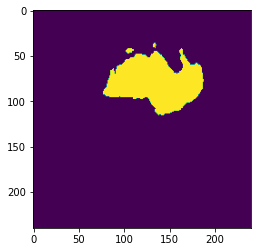

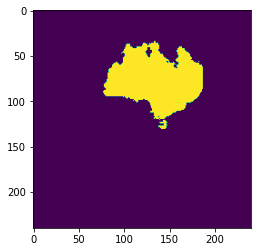

input_test 89


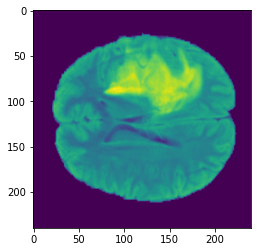

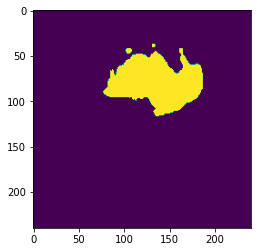

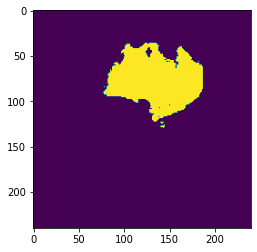

In [45]:
for i in range(80,90):
  print('input_test '+ str(i))
  plt.imshow(input_test[i,:,:,0])
  plt.show()
  plt.imshow(Y_pre_lowest_low[i,:,:,0])
  plt.show()
  plt.imshow(target_test[i,:,:,0])
  plt.show()

# Mirem el dice de tots els models amb les imatges de test

Dice model 1: 0.7970799088924151%
Dice model 2: 0.802882534298811%
Dice model 3: 0.8062769452753918%
Dice model 4: 0.8024762555293536%
Dice model 5: 0.8092396639123133%


{'whiskers': [<matplotlib.lines.Line2D at 0x7f99f1016860>,
 'caps': [<matplotlib.lines.Line2D at 0x7f99f1016e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f99f10165f8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f99f1026400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f99f10266d8>,
 'means': []}

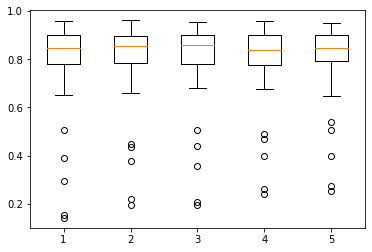

In [47]:
#Mirem dice dels 5 models per separat
dades_totals=[]
Y_pre1[np.where(Y_pre1<0.5)]=0
Y_pre1[np.where(Y_pre1>=0.5)]=1
Y_pre1=Y_pre1*input_test2
dades1=mean_dice_coef(target_test, Y_pre1)
print(f'Dice model 1: {np.mean(dades1)}%')
dades_totals.append(dades1)

Y_pre2[np.where(Y_pre2<0.5)]=0
Y_pre2[np.where(Y_pre2>=0.5)]=1
Y_pre2=Y_pre2*input_test2
dades2=mean_dice_coef(target_test, Y_pre2)
print(f'Dice model 2: {np.mean(dades2)}%')
dades_totals.append(dades2)

Y_pre3[np.where(Y_pre3<0.5)]=0
Y_pre3[np.where(Y_pre3>=0.5)]=1
Y_pre3=Y_pre3*input_test2
dades3=mean_dice_coef(target_test, Y_pre3)
print(f'Dice model 3: {np.mean(dades3)}%')
dades_totals.append(dades3)

Y_pre4[np.where(Y_pre4<0.5)]=0
Y_pre4[np.where(Y_pre4>=0.5)]=1
Y_pre4=Y_pre4*input_test2
dades4=mean_dice_coef(target_test, Y_pre4)
print(f'Dice model 4: {np.mean(dades4)}%')
dades_totals.append(dades4)

Y_pre5[np.where(Y_pre5<0.5)]=0
Y_pre5[np.where(Y_pre5>=0.5)]=1
Y_pre5=Y_pre5*input_test2
dades5=mean_dice_coef(target_test, Y_pre5)
print(f'Dice model 5: {np.mean(dades5)}%')
dades_totals.append(dades5)

#BOXPLOT
plt.boxplot(dades_totals)